In [1]:
# Core
import os
import importlib
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Model / Feature selection / Scaling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.svm import SVC, LinearSVC

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib


from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score
)

# Saving Model
import joblib

from scipy.stats import loguniform, randint


In [3]:
X_train = pd.read_csv('X_train.csv')
X_test  = pd.read_csv('X_test.csv')

y_train = pd.read_csv('Y_train.csv').squeeze("columns")  
y_test  = pd.read_csv('Y_test.csv').squeeze("columns")    # -> Series

X_train_Norway = pd.read_csv('X_train_Norway.csv')
X_test_Norway  = pd.read_csv('X_test_Norway.csv')

y_train_Norway = pd.read_csv('Y_train_Norway.csv').squeeze("columns")  
y_test_Norway  = pd.read_csv('Y_test_Norway.csv').squeeze("columns")    # -> Series
 

# Optional sanity check
print(y_train.value_counts(dropna=False))
print(y_train.dtype)


Label
LumA      230
LumB      102
Normal     70
Basal      70
Her2       24
Name: count, dtype: int64
object


## NO RFE NO CLASS IMBALANCE

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.0027814285643757543, 'svm__coef0': 0.02715581955282941, 'svm__degree': 2, 'svm__gamma': 0.037566296134528526, 'svm__kernel': 'poly'}

Test Accuracy (best model): 0.8467741935483871

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.94      0.94        17
        Her2       0.75      0.86      0.80         7
        LumA       0.86      0.86      0.86        58
        LumB       0.74      0.68      0.71        25
      Normal       0.89      0.94      0.91        17

    accuracy                           0.85       124
   macro avg       0.84      0.86      0.85       124
weighted avg       0.85      0.85      0.85       124



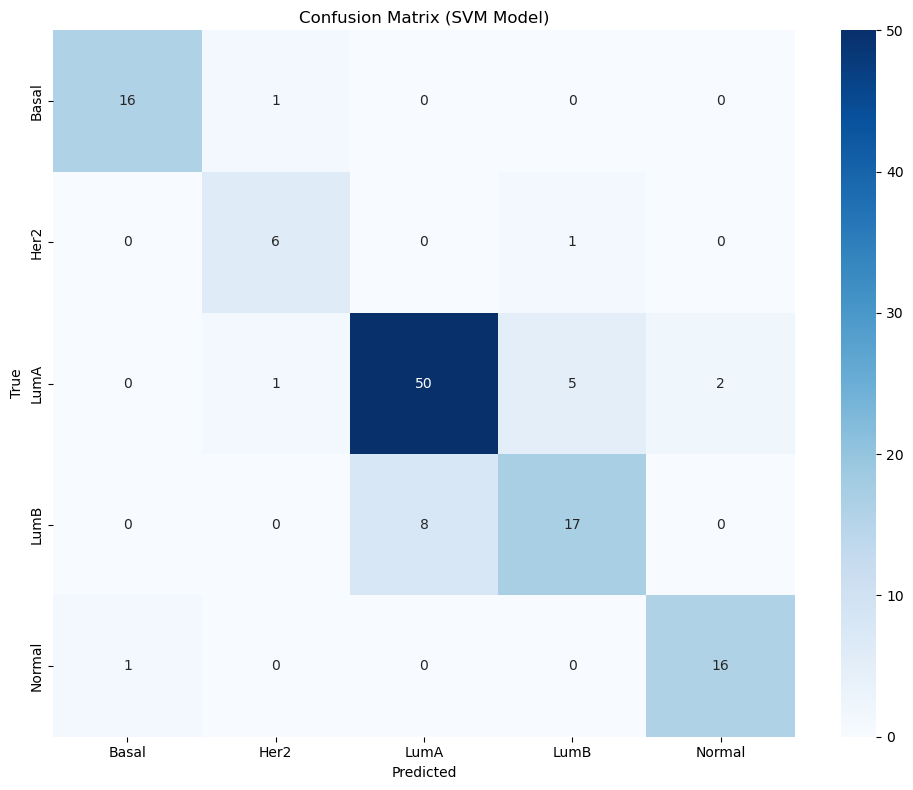

Model saved as svm_pipeline_svm.pkl


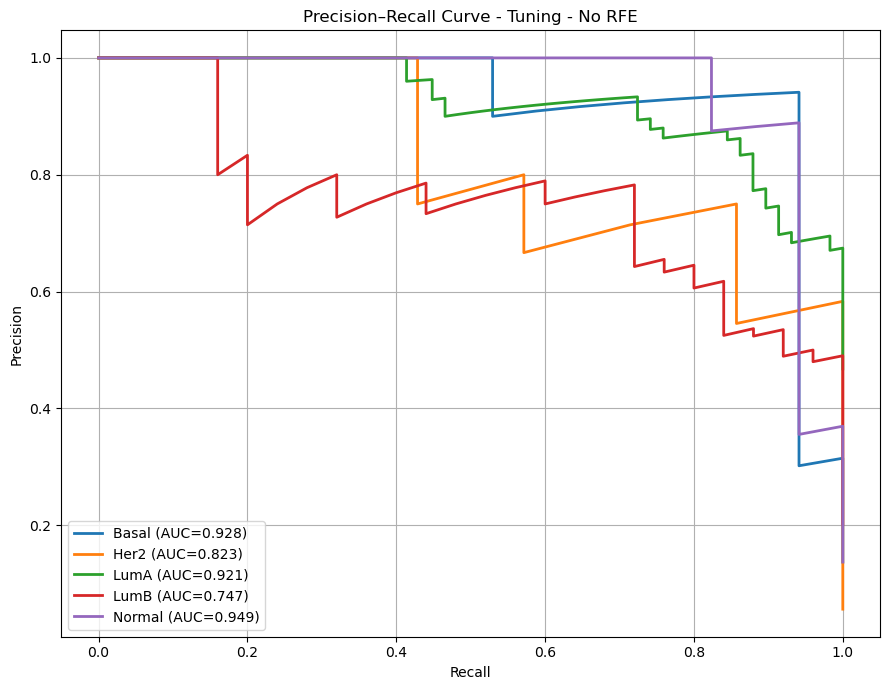

In [5]:
from scipy.stats import loguniform, randint
pipelineSvm = ImbPipeline([
    ('svm', SVC(kernel='linear', probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvm,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=-2,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSvm = rand.best_estimator_

y_pred = pipelineSvm.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

joblib.dump(pipelineSvm, "svm_pipeline_svm.pkl")

print("Model saved as svm_pipeline_svm.pkl")

# --- PRECISION–RECALL CURVE (MULTICLASS OVERRIDE) ---
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# 1. Get class names from the trained model
classes = pipelineSvm.named_steps['svm'].classes_

# 2. Binarize the true labels for One-vs-Rest PR curves
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities for each class
y_proba = pipelineSvm.predict_proba(X_test)

# 4. Plot PR curve for each class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve - Tuning - No RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_Tuning_NoRFE.png", dpi=300)
plt.show()





Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.0027814285643757543, 'svm__coef0': 0.02715581955282941, 'svm__degree': 2, 'svm__gamma': 0.037566296134528526, 'svm__kernel': 'poly'}

Test Accuracy (best model): 0.75

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.75      0.43      0.55         7
        LumA       0.71      0.87      0.78        23
        LumB       0.69      0.75      0.72        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.75        52
   macro avg       0.63      0.61      0.61        52
weighted avg       0.71      0.75      0.72        52



c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


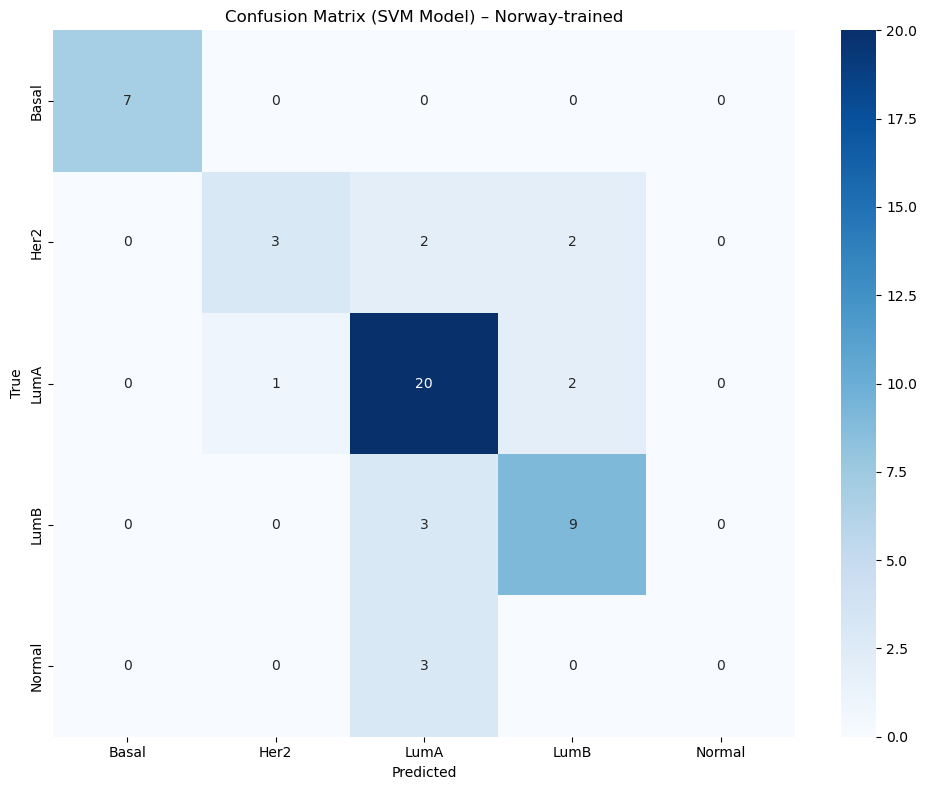

Model saved as svm_pipeline_Norway.pkl

Norway Test Macro-Average AUC-PR (pipelineSvm): 0.691


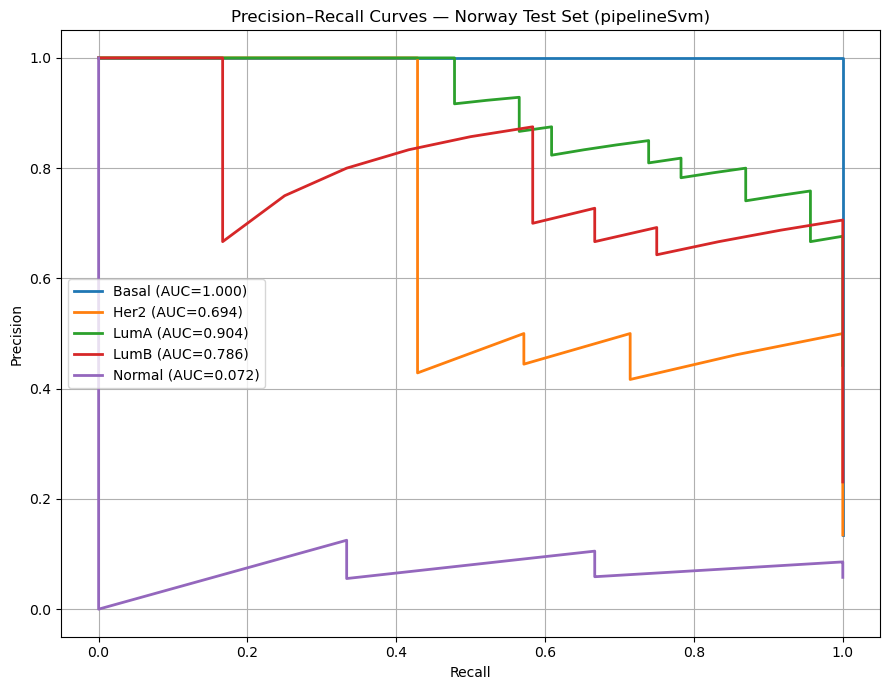

In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# -------------------------------
# Train SVM on NORWAY training set
# -------------------------------
pipelineNoRFEWithTuning = ImbPipeline([
    ('svm', SVC(kernel='linear',
                probability=True,
                random_state=42))
])

param_dist = [
    {  # linear
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineNoRFEWithTuning,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineNoRFEWithTuning = rand.best_estimator_

pipelineNoRFEWithTuning.fit(X_train_Norway, y_train_Norway)


# -------------------------------
# Evaluate on NORWAY test set
# -------------------------------
y_pred = pipelineNoRFEWithTuning.predict(X_test_Norway)
print("\nTest Accuracy (best model):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model) – Norway-trained')
plt.tight_layout()
plt.show()

joblib.dump(pipelineNoRFEWithTuning, "svm_pipeline_Norway.pkl")
print("Model saved as svm_pipeline_Norway.pkl")

# -------------------------------
# Precision–Recall Curves (multiclass, Norway test set)
# -------------------------------
classes = pipelineNoRFEWithTuning.named_steps['svm'].classes_

# Binarize true labels (one-vs-rest)
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineNoRFEWithTuning.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (pipelineSvm): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (pipelineSvm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_NORFE_TUNING_trainedOnNorway.png", dpi=300)
plt.show()


## RFE and Tuning

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.8064516129032258

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.71      0.71      0.71         7
        LumA       0.79      0.84      0.82        58
        LumB       0.75      0.60      0.67        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.81       124
   macro avg       0.81      0.80      0.80       124
weighted avg       0.81      0.81      0.80       124



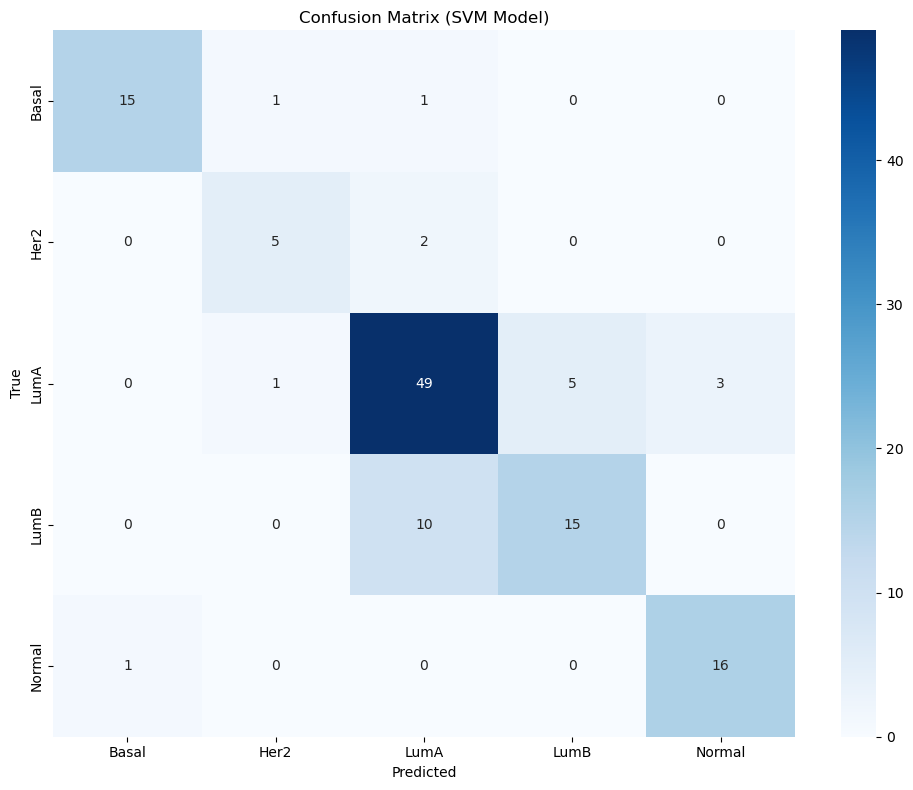

Model saved as pipelineSvmRfeTune.pkl


In [ ]:
from sklearn.feature_selection import RFE
pipelineSvmRfeTune = ImbPipeline([
     ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmRfeTune,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSvmRfeTune = rand.best_estimator_

pipelineSvmRfeTune.fit(X_train, y_train)
y_pred = pipelineSvmRfeTune.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

joblib.dump(pipelineSvmRfeTune, "pipelineSvmRfeTune.pkl")

print("Model saved as pipelineSvmRfeTune.pkl")

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ----- PRECISION–RECALL CURVES for pipelineSvmRfe -----

# 1. Get class labels from the final SVM inside the pipeline
classes = pipelineSvmRfeTune.named_steps['svm'].classes_

# 2. Binarize y_test for One-vs-Rest PR curves
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities from the pipeline
y_proba = pipelineSvmRfeTune.predict_proba(X_test)   # shape: (n_samples, n_classes)

# 4. Plot PR curve for each class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, label=f"{cls} (AUC = {auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Tuning - RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_Tuning_RFE.png", dpi=300)
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting estimator with 20789 features.
Fitting estimator with 15592 features.
Fitting estimator with 10395 features.
Fitting estimator with 5198 features.
{'svm__C': 3.3151790861321726, 'svm__gamma': 0.0670311293206946, 'svm__kernel': 'rbf'}

Test Accuracy (RFE Tuned SVM, Norway): 0.7307692307692307

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.60      0.43      0.50         7
        LumA       0.75      0.91      0.82        23
        LumB       0.58      0.58      0.58        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.73        52
   macro avg       0.59      0.58      0.58        52
weighted avg       0.68      0.73      0.70        52



C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


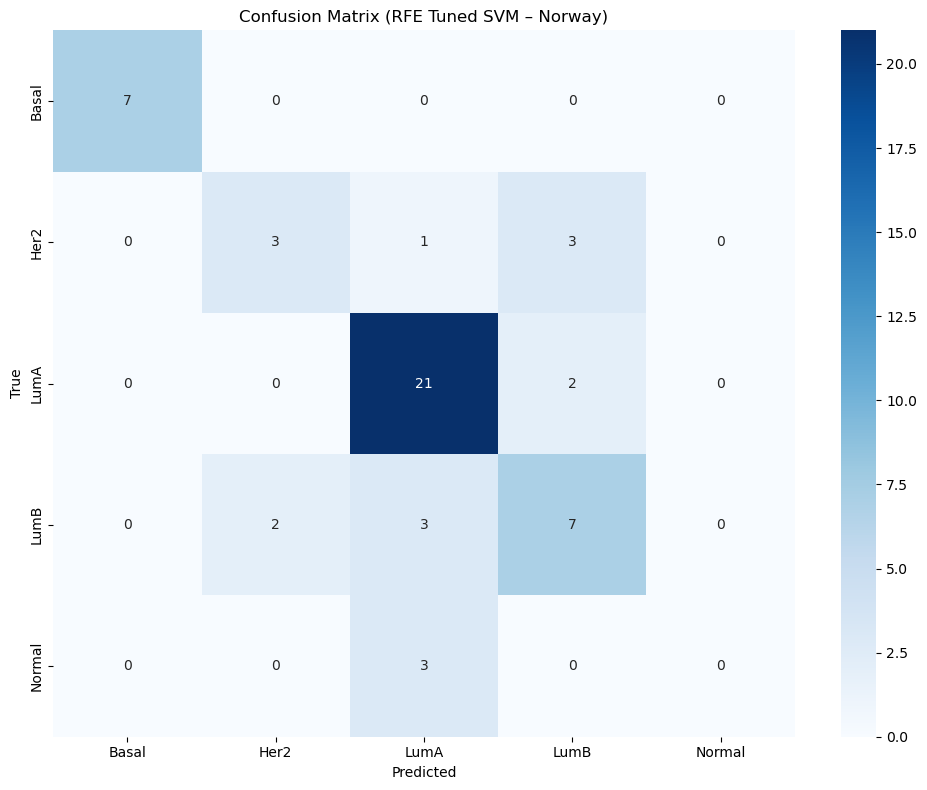

Model saved as pipelineSvmRfeTune_Norway.pkl

Norway Test Macro-Average AUC-PR (RFE Tuned SVM): 0.657


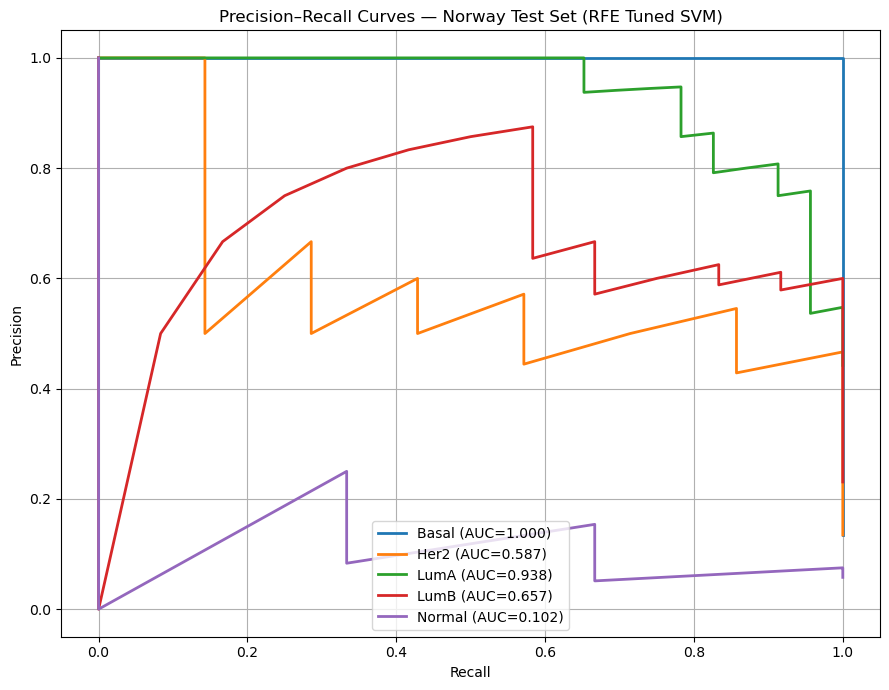

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC, SVC
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# -------------------------------
# 1. Define RFE + Tuned SVM pipeline (Norway)
# -------------------------------

pipelineSvmRfeTuneNorway = ImbPipeline([
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False),
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='linear', C=0.1767016940294795, probability=True, random_state=42))
])

param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmRfeTuneNorway,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train_Norway, y_train_Norway)
print(rand.best_params_)
pipelineSvmRfeTuneNorway = rand.best_estimator_

# -------------------------------
# 2. Train on Norway dataset
# -------------------------------
#pipelineSvmRfeTuneNorway.fit(X_train_Norway, y_train_Norway)

# -------------------------------
# 3. Predict & Evaluate
# -------------------------------
y_pred = pipelineSvmRfeTuneNorway.predict(X_test_Norway)

print("\nTest Accuracy (RFE Tuned SVM, Norway):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (RFE Tuned SVM – Norway)')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Save the trained pipeline
# -------------------------------
joblib.dump(pipelineSvmRfeTuneNorway, "pipelineSvmRfeTune_Norway.pkl")
print("Model saved as pipelineSvmRfeTune_Norway.pkl")

# -------------------------------
# 5. Precision–Recall Curves (multiclass)
# -------------------------------
classes = pipelineSvmRfeTuneNorway.named_steps['svm'].classes_

# Binarize true labels
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineSvmRfeTuneNorway.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (RFE Tuned SVM): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (RFE Tuned SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_RFE_TUNING.png", dpi=300)
plt.show()


In [ ]:
import shap

# --- Create SHAP explainer (linear kernel → fast linear explainer)
svm = pipelineSvm.named_steps['svm']

bg = shap.sample(X_train, 200, random_state=42) if len(X_train) > 200 else X_train
masker = shap.maskers.Independent(bg)
explainer = shap.Explainer(svm, masker=masker, algorithm="linear")

# Compute SHAP values (multiclass)
sv = explainer(X_test)

# --- Generate and SHOW the plots (Top 10 features, x-ticks every 0.01)
from matplotlib.ticker import MultipleLocator
import numpy as np
class_names = pd.Index(svm.classes_)

for ci, cname in enumerate(class_names):
    sv_c = sv[:, :, ci]  # SHAP for this class

    # symmetric x-limits rounded to nearest 0.01
    vmax = float(np.nanmax(np.abs(np.asarray(sv_c.values))))
    xmax = max(0.01, np.ceil(vmax * 100) / 100.0)

    plt.figure(figsize=(8, 5.5))
    shap.plots.beeswarm(sv_c, max_display=10, show=False)
    ax = plt.gca()
    ax.set_title(f"SHAP Beeswarm — Top 10 Features ({cname} Subtype)")
    ax.set_xlabel("SHAP value (impact on decision margin)")
    ax.set_xlim(-xmax, xmax)
    ax.xaxis.set_major_locator(MultipleLocator(0.01))
    plt.tight_layout()
    plt.show()


# Irus Models

## No RFE with Tuning

In [4]:
def get_irus_sampling_strategy(y):
    counts = Counter(y)
    majority_class = max(counts, key=counts.get)
    minority_class = min(counts, key=counts.get)
    imbalance_ratio = counts[majority_class] / counts[minority_class]
    
    # IRUS formula: inverse of square root of imbalance ratio
    sampling_ratio = 1 / np.sqrt(imbalance_ratio)
    
    # Calculate number of samples to keep for majority class
    n_samples_majority = int(counts[minority_class] / sampling_ratio)
    
    return {majority_class: n_samples_majority}

# Get IRUS sampling strategy based on training data
irus_strategy = get_irus_sampling_strategy(y_train)





Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 0.03987365855896373, 'svm__kernel': 'linear'}

Test Accuracy (best model): 0.7580645161290323

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.75      0.86      0.80         7
        LumA       0.92      0.60      0.73        58
        LumB       0.55      0.88      0.68        25
      Normal       0.73      0.94      0.82        17

    accuracy                           0.76       124
   macro avg       0.78      0.83      0.79       124
weighted avg       0.81      0.76      0.76       124



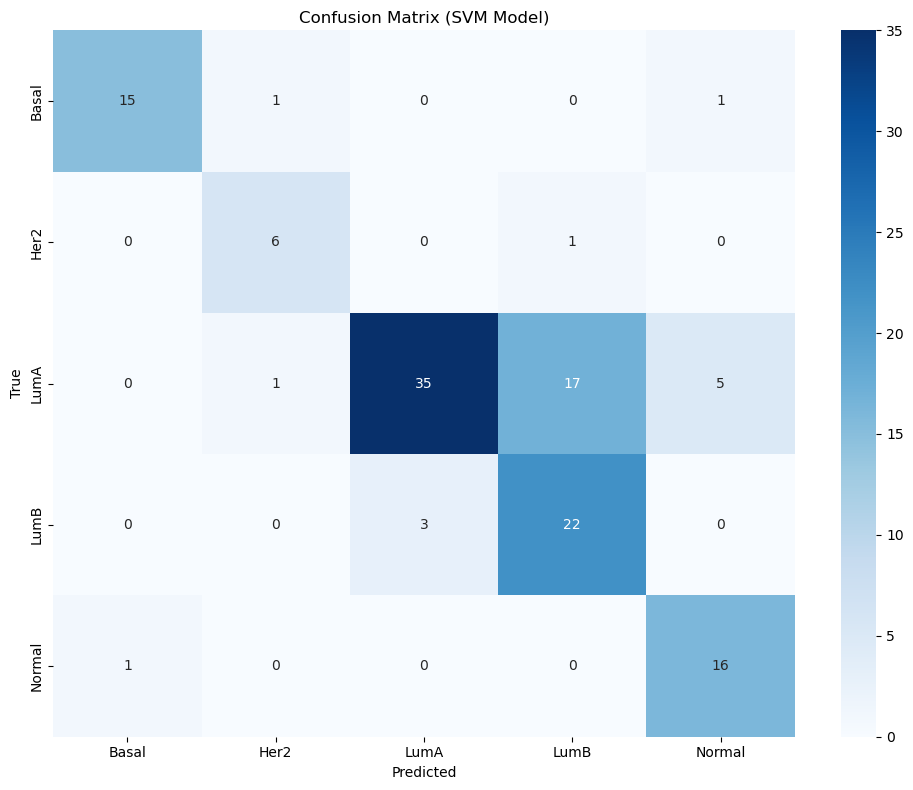

Model saved as svm_pipeline_Irus.pkl


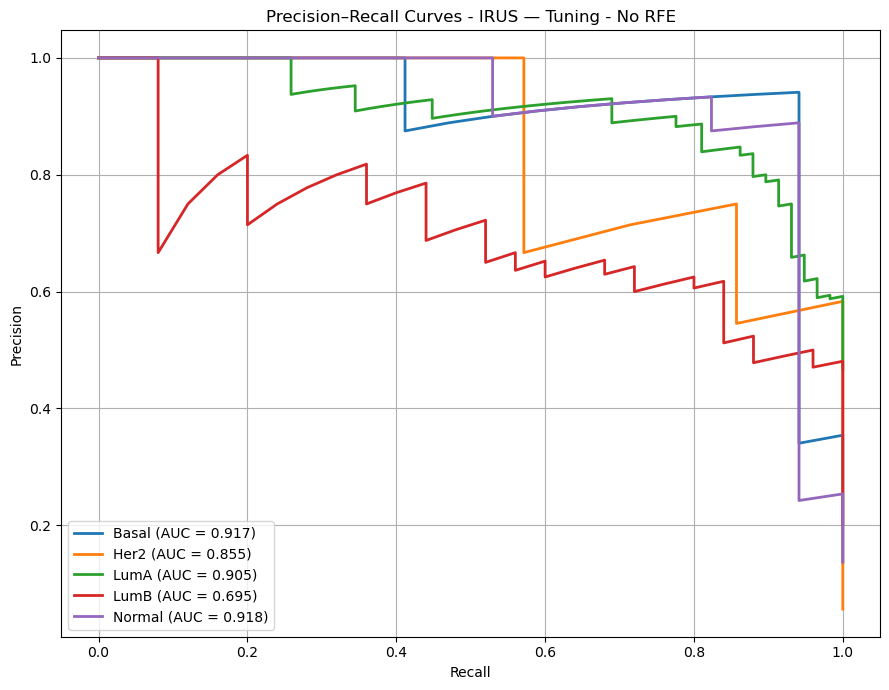

In [7]:
# Define pipeline with IRUS and RFE for SVM

pipelineSvmIrus = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='linear',  probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmIrus,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSvmIrus = rand.best_estimator_

pipelineSvmIrus.fit(X_train, y_train)
y_pred = pipelineSvmIrus.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(pipelineSvmIrus, "svm_pipeline_Irus.pkl")

print("Model saved as svm_pipeline_Irus.pkl")

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ----- PRECISION–RECALL CURVES for pipelineSvmIrus -----

# 1. Get class labels from the final SVM inside the pipeline
classes = pipelineSvmIrus.named_steps['svm'].classes_

# 2. Binarize the true labels for One-vs-Rest
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities from the IRUS pipeline
y_proba = pipelineSvmIrus.predict_proba(X_test)

# 4. Plot PR curve for each class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC = {auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - IRUS — Tuning - No RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_IRUS_Tuning_NoRFE.png", dpi=300)
plt.show()


Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'svm__C': 199.37998248613215, 'svm__gamma': 4.185285656222354e-05, 'svm__kernel': 'rbf'}

Test Accuracy (IRUS + Tuned SVM, Norway): 0.7115384615384616

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.57      0.57      0.57         7
        LumA       0.88      0.61      0.72        23
        LumB       0.55      1.00      0.71        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.71        52
   macro avg       0.60      0.64      0.60        52
weighted avg       0.72      0.71      0.69        52



c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


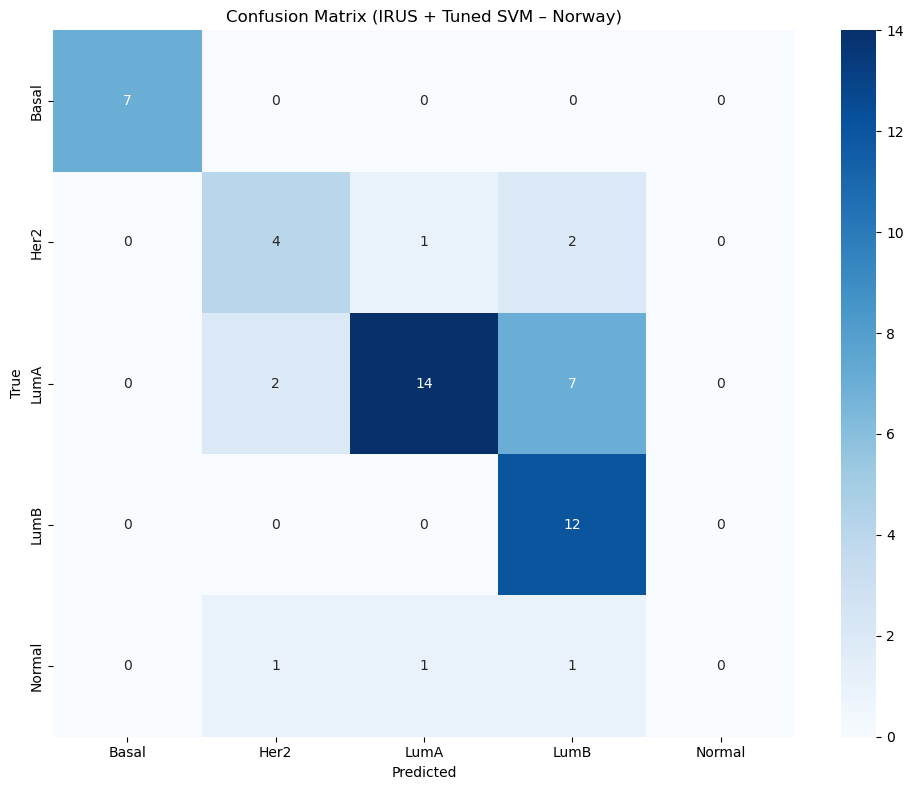

Model saved as svm_pipeline_Irus_Norway.pkl

Norway Test Macro-Average AUC-PR (IRUS + Tuned SVM): 0.749


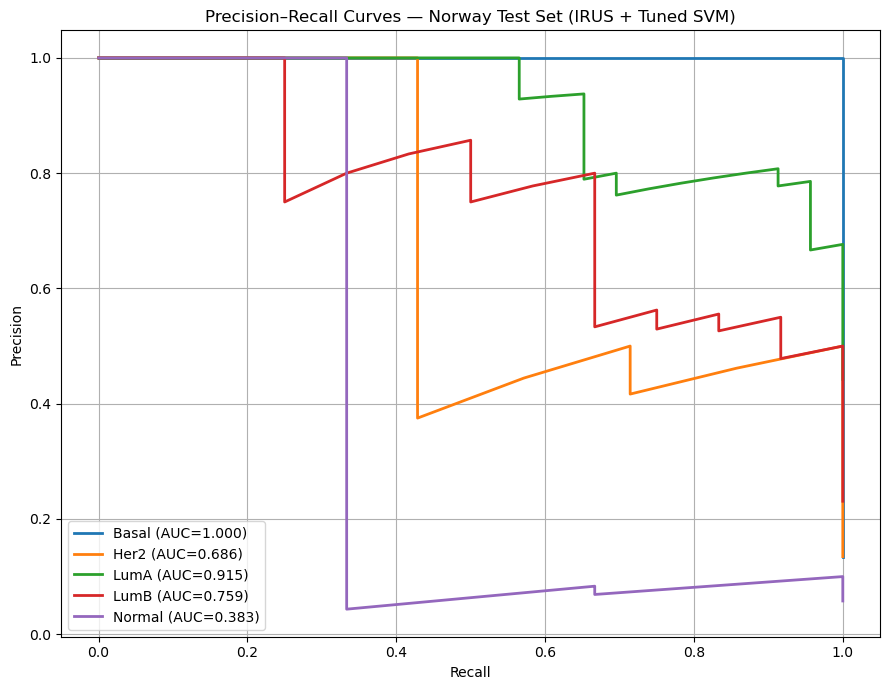

In [12]:

# -------------------------------
# 2. Define pipeline (IRUS + tuned SVM, no RFE)
# -------------------------------
pipelineSvmIrusNorway = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('svm', SVC(kernel='linear',
                probability=True,
                random_state=42))
])

# -------------------------------
# 3. Train pipeline on Norway
# -------------------------------
param_dist = [
    {  # linear
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmIrusNorway,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=12,
    verbose=3,
    random_state=42
)


rand.fit(X_train_Norway, y_train_Norway)
print(rand.best_params_)
pipelineSvmIrusNorway = rand.best_estimator_

pipelineSvmIrusNorway.fit(X_train_Norway, y_train_Norway)

# -------------------------------
# 4. Evaluate on Norway test set
# -------------------------------
y_pred = pipelineSvmIrusNorway.predict(X_test_Norway)
print("\nTest Accuracy (IRUS + Tuned SVM, Norway):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (IRUS + Tuned SVM – Norway)')
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Save the trained model
# -------------------------------
joblib.dump(pipelineSvmIrusNorway, "svm_pipeline_Irus_Norway.pkl")
print("Model saved as svm_pipeline_Irus_Norway.pkl")

# -------------------------------
# 6. Precision–Recall Curves (multiclass)
# -------------------------------
classes = pipelineSvmIrusNorway.named_steps['svm'].classes_

# Binarize true labels
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineSvmIrusNorway.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (IRUS + Tuned SVM): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (IRUS + Tuned SVM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_IRUS_TUNED_NO_RFE.png", dpi=300)
plt.show()


## RFE with Tuning

Fitting estimator with 19277 features.
Fitting estimator with 14458 features.
Fitting estimator with 9639 features.
Fitting estimator with 4820 features.

Test Accuracy (best model): 0.7338709677419355

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.84      0.94      0.89        17
        Her2       0.80      0.57      0.67         7
        LumA       0.87      0.59      0.70        58
        LumB       0.50      0.84      0.63        25
      Normal       0.84      0.94      0.89        17

    accuracy                           0.73       124
   macro avg       0.77      0.78      0.75       124
weighted avg       0.78      0.73      0.74       124



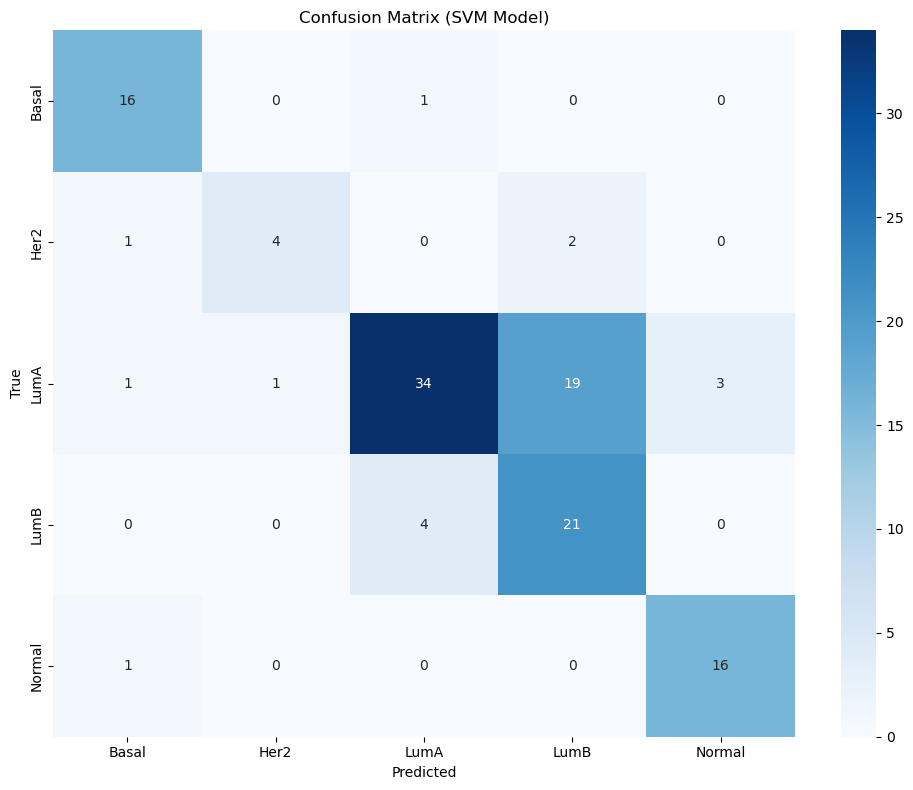

Model saved as pipelineSvmIrusRFETune.pkl


In [ ]:
pipelineSvmIrusRFETune = ImbPipeline([
     ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='linear' , probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmIrusRFETune,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSvmIrusRFETune = rand.best_estimator_

pipelineSvmIrusRFETune.fit(X_train, y_train)
y_pred = pipelineSvmIrusRFETune.predict(X_test)
print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(pipelineSvmIrusRFETune, "pipelineSvmIrusRFETune.pkl")

print("Model saved as pipelineSvmIrusRFETune.pkl")

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# ----- PRECISION–RECALL CURVES for pipelineSvmIrusRFETune -----

# 1. Get class labels from the final SVM inside the pipeline
classes = pipelineSvmIrusRFETune.named_steps['svm'].classes_

# 2. Binarize y_test for One-vs-Rest
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities (from the RBF SVM)
y_proba = pipelineSvmIrusRFETune.predict_proba(X_test)

# 4. Plot PR curve for each class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC = {auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - IRUS — Tuning - RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_IRUS_Tuning_RFE.png", dpi=300)
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting estimator with 20789 features.
Fitting estimator with 15592 features.
Fitting estimator with 10395 features.
Fitting estimator with 5198 features.
{'svm__C': 3.3151790861321726, 'svm__gamma': 0.0670311293206946, 'svm__kernel': 'rbf'}
Fitting estimator with 20789 features.
Fitting estimator with 15592 features.
Fitting estimator with 10395 features.
Fitting estimator with 5198 features.

Test Accuracy (IRUS + RFE Tuned SVM, Norway): 0.6730769230769231

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.60      0.43      0.50         7
        LumA       0.87      0.57      0.68        23
        LumB       0.46      0.92      0.61        12
      Normal       1.00      0.33      0.50         3

    accuracy                           0.67        52
   macro avg       0.79      0.65      0.66        52
weighted a

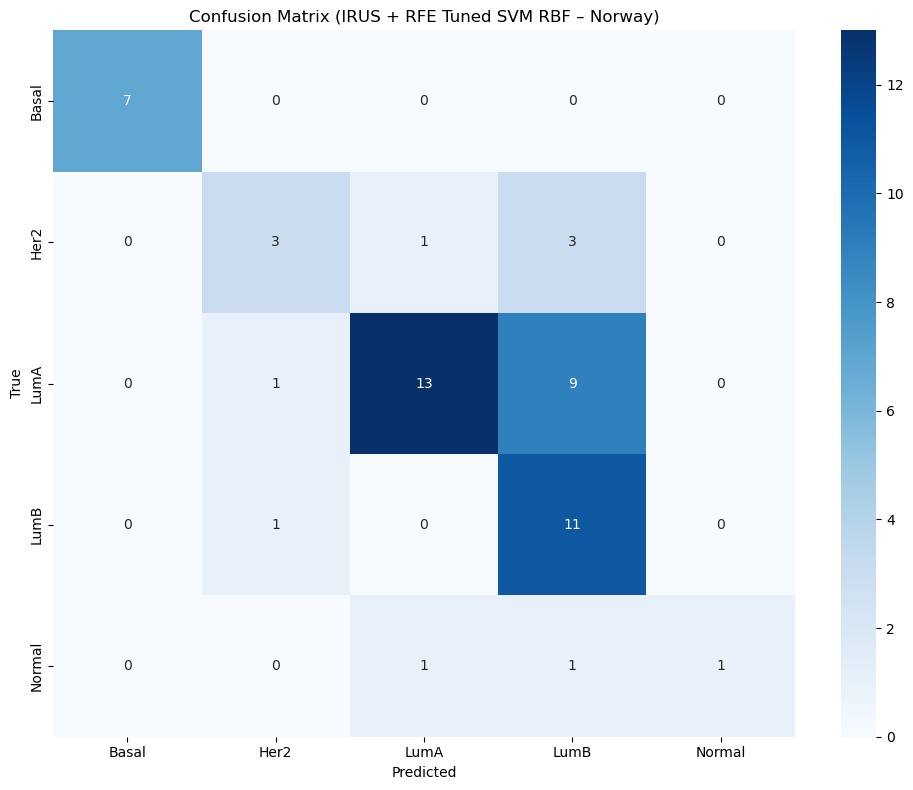

Model saved as pipelineSvmIrusRFETune_Norway.pkl

Norway Test Macro-Average AUC-PR (IRUS + RFE Tuned SVM RBF): 0.717


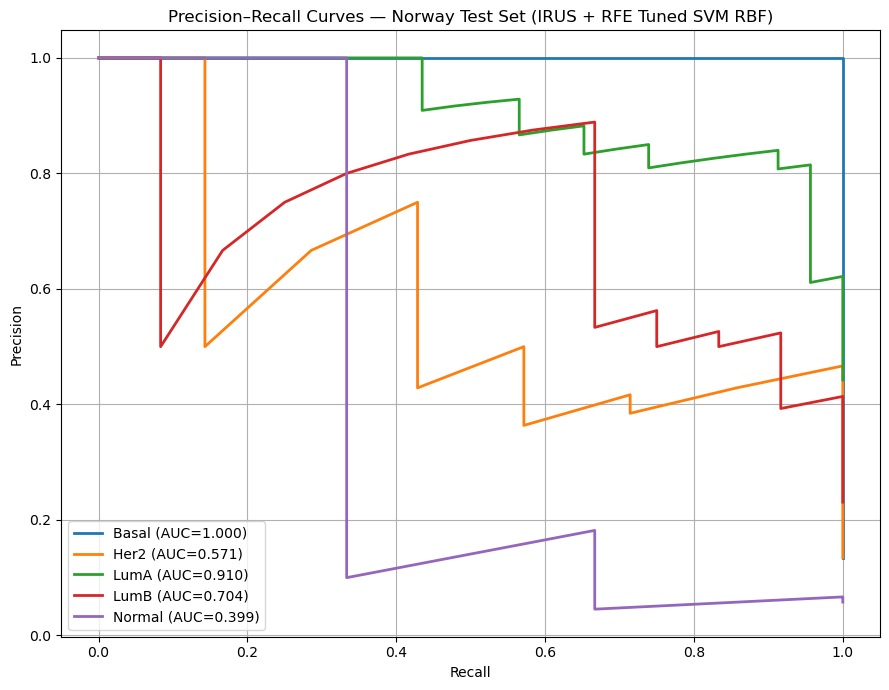

In [ ]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib


# -------------------------------
# 2. Define pipeline (IRUS + RFE + Tuned SVM RBF)
# -------------------------------
pipelineSvmIrusRFETuneNorway = ImbPipeline([
    ('irus', RandomUnderSampler(sampling_strategy=irus_strategy, random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False),
                n_features_to_select=500, step=0.25, verbose=1)),
    ('svm', SVC(kernel='rbf',
                probability=True,
                random_state=42))
])

# -------------------------------
# 3. Train pipeline on Norway
# -------------------------------
param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmIrusRFETuneNorway,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train_Norway, y_train_Norway)
print(rand.best_params_)
pipelineSvmIrusRFETuneNorway = rand.best_estimator_

pipelineSvmIrusRFETuneNorway.fit(X_train_Norway, y_train_Norway)


# -------------------------------
# 4. Predict & Evaluate
# -------------------------------
y_pred = pipelineSvmIrusRFETuneNorway.predict(X_test_Norway)
print("\nTest Accuracy (IRUS + RFE Tuned SVM, Norway):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (IRUS + RFE Tuned SVM RBF – Norway)')
plt.tight_layout()
plt.show()

# -------------------------------
# 5. Save the trained pipeline
# -------------------------------
joblib.dump(pipelineSvmIrusRFETuneNorway, "pipelineSvmIrusRFETune_Norway.pkl")
print("Model saved as pipelineSvmIrusRFETune_Norway.pkl")

# -------------------------------
# 6. Precision–Recall Curves (multiclass)
# -------------------------------
classes = pipelineSvmIrusRFETuneNorway.named_steps['svm'].classes_

# Binarize true labels
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineSvmIrusRFETuneNorway.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (IRUS + RFE Tuned SVM RBF): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (IRUS + RFE Tuned SVM RBF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_IRUS_RFE_TUNING_RBF.png", dpi=300)
plt.show()


## RFE No Tuning

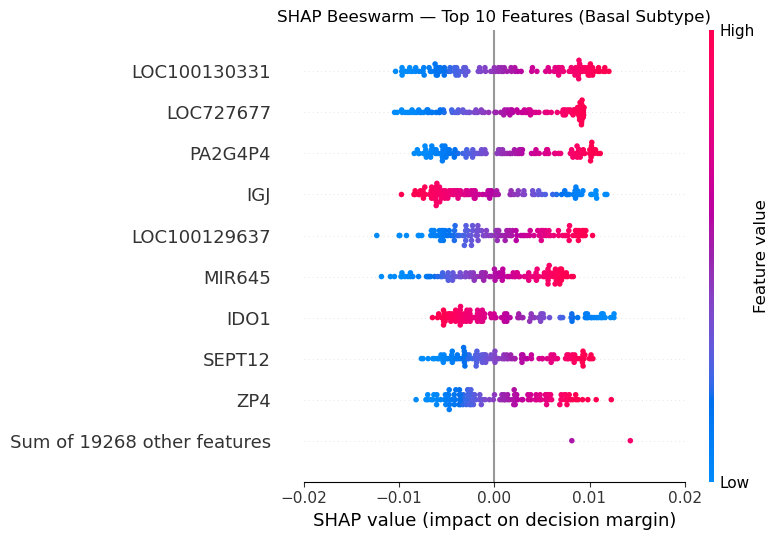

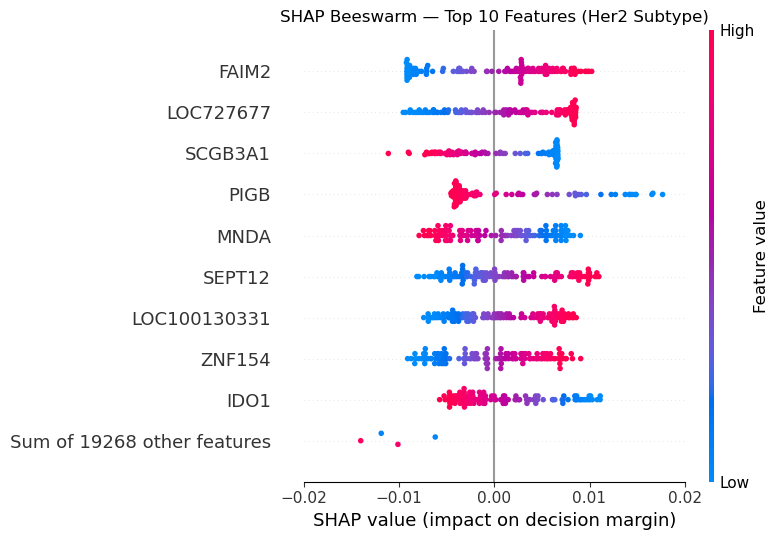

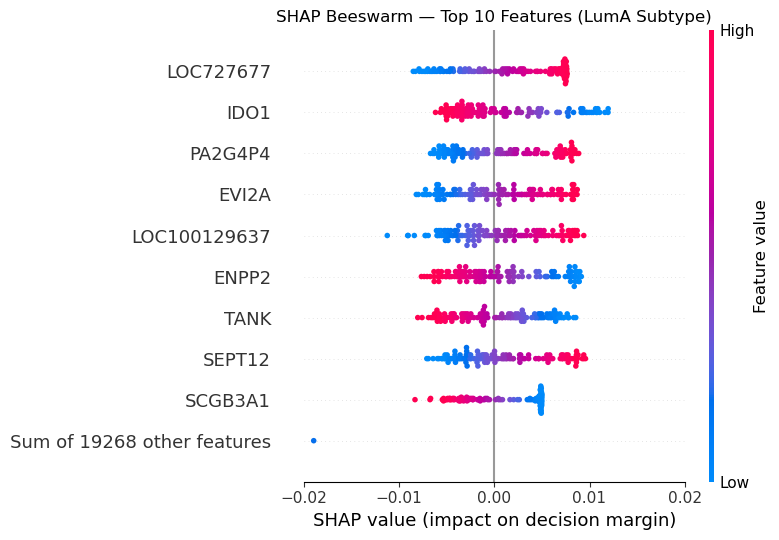

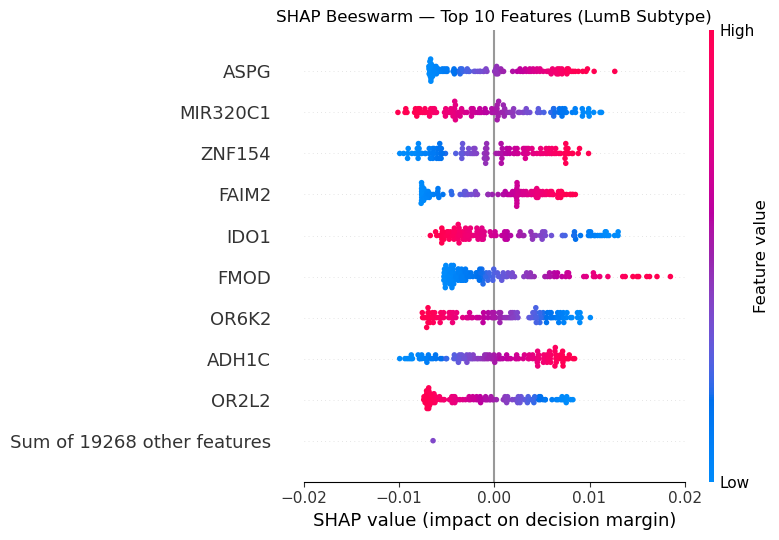

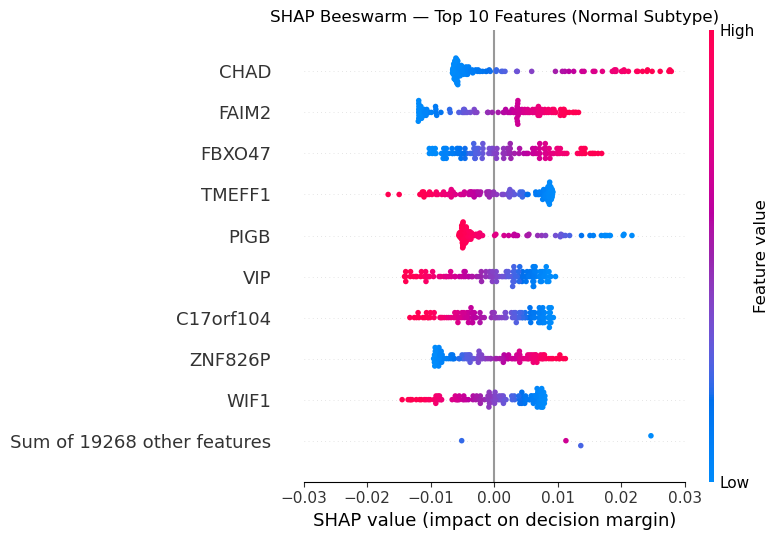

In [37]:
# --- Create SHAP explainer (linear kernel → fast linear explainer)
svm = pipelineSmote.named_steps['svm']

bg = shap.sample(X_train, 200, random_state=42) if len(X_train) > 200 else X_train
masker = shap.maskers.Independent(bg)
explainer = shap.Explainer(svm, masker=masker, algorithm="linear")

# Compute SHAP values (multiclass)
sv = explainer(X_test)

# --- Generate and SHOW the plots (Top 10 features, x-ticks every 0.01)
from matplotlib.ticker import MultipleLocator
import numpy as np
class_names = pd.Index(svm.classes_)

for ci, cname in enumerate(class_names):
    sv_c = sv[:, :, ci]  # SHAP for this class

    # symmetric x-limits rounded to nearest 0.01
    vmax = float(np.nanmax(np.abs(np.asarray(sv_c.values))))
    xmax = max(0.01, np.ceil(vmax * 100) / 100.0)

    plt.figure(figsize=(8, 5.5))
    shap.plots.beeswarm(sv_c, max_display=10, show=False)
    ax = plt.gca()
    ax.set_title(f"SHAP Beeswarm — Top 10 Features ({cname} Subtype)")
    ax.set_xlabel("SHAP value (impact on decision margin)")
    ax.set_xlim(-xmax, xmax)
    ax.xaxis.set_major_locator(MultipleLocator(0.01))
    plt.tight_layout()
    plt.show()


# Smote Models

## Random Search NO RFE

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'smote__k_neighbors': 5, 'svm__C': 199.37998248613215, 'svm__gamma': 4.185285656222354e-05, 'svm__kernel': 'rbf'}

Test Accuracy (best model): 0.8225806451612904

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.94      0.88      0.91        17
        Her2       0.75      0.86      0.80         7
        LumA       0.86      0.83      0.84        58
        LumB       0.74      0.68      0.71        25
      Normal       0.76      0.94      0.84        17

    accuracy                           0.82       124
   macro avg       0.81      0.84      0.82       124
weighted avg       0.83      0.82      0.82       124



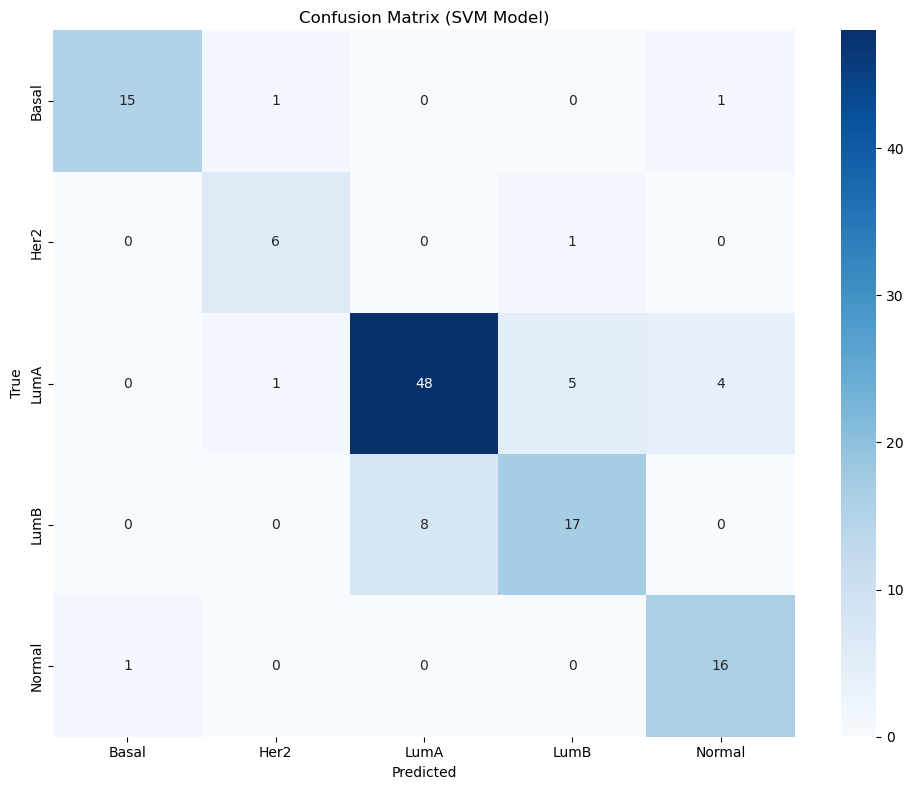

Model saved as svm_pipeline_smote.pkl


In [9]:
from sklearn.feature_selection import RFE
pipelineSmote = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='linear', probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'smote__k_neighbors': [3, 5, 7],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'smote__k_neighbors': [3, 5, 7],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'smote__k_neighbors': [3, 5, 7],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSmote,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=-3,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSmote = rand.best_estimator_

pipelineSmote.fit(X_train, y_train)
y_pred = pipelineSmote.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(pipelineSmote, "svm_pipeline_smote.pkl")

print("Model saved as svm_pipeline_smote.pkl")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'smote__k_neighbors': 5, 'svm__C': 0.007197818769068854, 'svm__kernel': 'linear'}

Test Accuracy (SMOTE + SVM, Norway, Random Search tuning): 0.7884615384615384

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.50      0.43      0.46         7
        LumA       0.87      0.87      0.87        23
        LumB       0.67      0.83      0.74        12
      Normal       1.00      0.33      0.50         3

    accuracy                           0.79        52
   macro avg       0.81      0.69      0.71        52
weighted avg       0.80      0.79      0.78        52



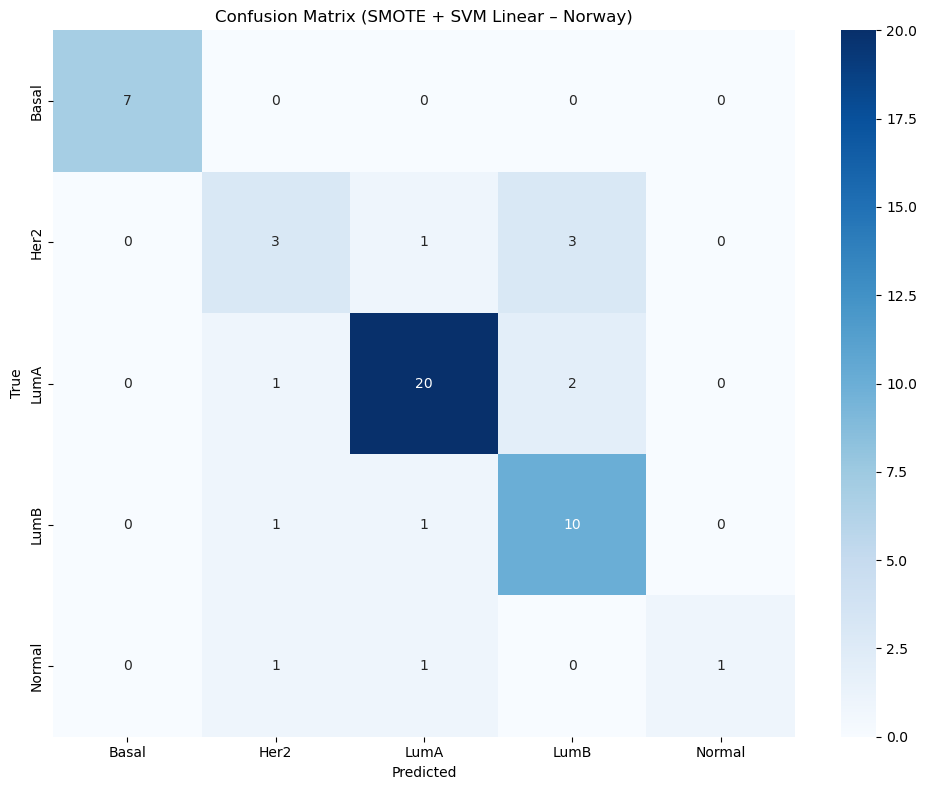

Model saved as svm_pipeline_smote_Norway.pkl

Norway Test Macro-Average AUC-PR (SMOTE + SVM Linear, Random Search): 0.776


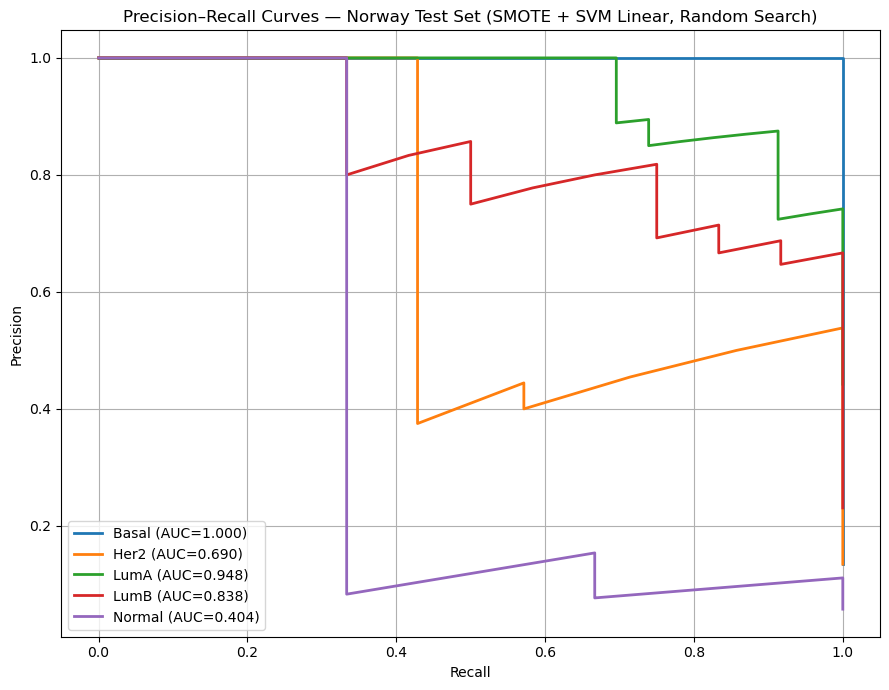

In [7]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# -------------------------------
# 1. Define SMOTE + SVM (linear, Random Search tuned, no RFE)
# -------------------------------
pipelineSmoteNorway = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', SVC(kernel='linear',
                probability=True,
                random_state=42))
])

# -------------------------------
# 2. Train pipeline on Norway
# -------------------------------
param_dist = [
    {  # linear
        'smote__k_neighbors': [3, 5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'smote__k_neighbors': [3, 5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'smote__k_neighbors': [3, 5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSmoteNorway,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=-2,
    verbose=3,
    random_state=42
)

rand.fit(X_train_Norway, y_train_Norway)
print(rand.best_params_)
pipelineSmoteNorway = rand.best_estimator_

# -------------------------------
# 3. Predict & Evaluate
# -------------------------------
y_pred = pipelineSmoteNorway.predict(X_test_Norway)
print("\nTest Accuracy (SMOTE + SVM, Norway, Random Search tuning):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SMOTE + SVM Linear – Norway)')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Save the trained model
# -------------------------------
joblib.dump(pipelineSmoteNorway, "svm_pipeline_smote_Norway.pkl")
print("Model saved as svm_pipeline_smote_Norway.pkl")

# -------------------------------
# 5. Precision–Recall Curves (multiclass)
# -------------------------------
classes = pipelineSmoteNorway.named_steps['svm'].classes_

# Binarize true labels
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineSmoteNorway.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (SMOTE + SVM Linear, Random Search): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (SMOTE + SVM Linear, Random Search)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_SMOTE_RandomSearch.png", dpi=300)
plt.show()


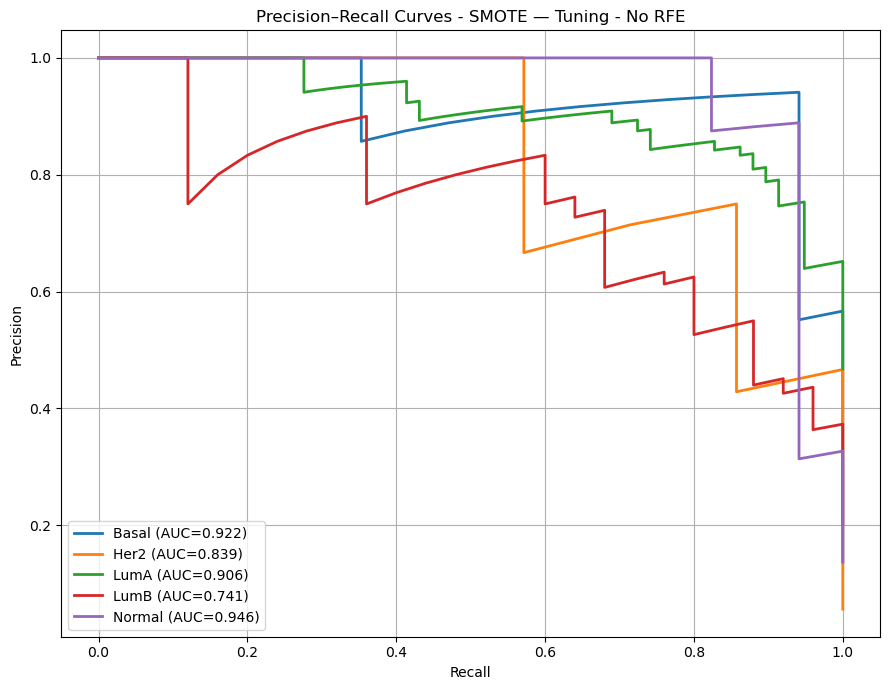

In [195]:
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- PRECISION–RECALL CURVES for pipelineSmote ---

# 1. Get class labels from the final SVM
classes = pipelineSmote.named_steps['svm'].classes_

# 2. Binarize y_test for One-vs-Rest PR curves
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities for each class
y_proba = pipelineSmote.predict_proba(X_test)

# 4. Plot PR curve for each class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - SMOTE — Tuning - No RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_SMOTE_Tuning_NoRFE.png", dpi=300)
plt.show()



## Random Search RFE

Fitting estimator with 19277 features.
Fitting estimator with 15422 features.
Fitting estimator with 11567 features.
Fitting estimator with 7712 features.
Fitting estimator with 3857 features.

Test Accuracy (best model): 0.8064516129032258

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       0.89      0.94      0.91        17
        Her2       0.71      0.71      0.71         7
        LumA       0.84      0.79      0.81        58
        LumB       0.71      0.68      0.69        25
      Normal       0.80      0.94      0.86        17

    accuracy                           0.81       124
   macro avg       0.79      0.81      0.80       124
weighted avg       0.81      0.81      0.80       124



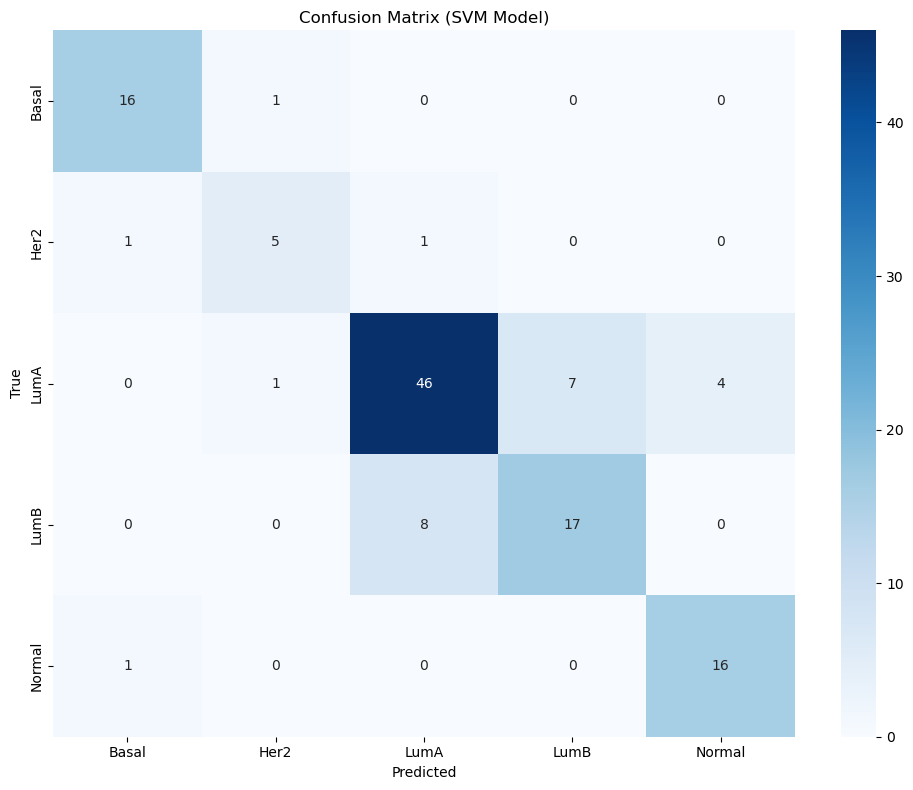

Model saved as pipelineSvmSmoteRfeTune.pkl


In [ ]:
pipelineSvmSmoteRfeTune = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False), 
                n_features_to_select=500, step=0.20, verbose=1)),
    ('svm', SVC(kernel='rbf' , probability=True, random_state=42))  # Using SVC as the final classifier
])

param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSvmSmoteRfeTune,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)

rand.fit(X_train, y_train)
print(rand.best_params_)
pipelineSvmSmoteRfeTune = rand.best_estimator_

pipelineSvmSmoteRfeTune.fit(X_train, y_train)
y_pred = pipelineSvmSmoteRfeTune.predict(X_test)

print("\nTest Accuracy (best model):", accuracy_score(y_test, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test, y_pred))

import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SVM Model)')
plt.tight_layout()
plt.show()

# Save the model
joblib.dump(pipelineSvmSmoteRfeTune, "pipelineSvmSmoteRfeTune.pkl")

print("Model saved as pipelineSvmSmoteRfeTune.pkl")

from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# --- PRECISION–RECALL CURVES for pipelineSvmSmoteRfeTune ---

# 1. Get class labels from the final SVM inside the pipeline
classes = pipelineSvmSmoteRfeTune.named_steps['svm'].classes_

# 2. Binarize the y_test labels for multiclass PR (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=classes)

# 3. Get predicted probabilities for each class
y_proba = pipelineSvmSmoteRfeTune.predict_proba(X_test)

# 4. Plot PR curve per class
plt.figure(figsize=(9, 7))

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves - SMOTE — Tuning - RFE")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_curve_SMOTE_Tuning_RFE.png", dpi=300)
plt.show()


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting estimator with 20789 features.
Fitting estimator with 16632 features.
Fitting estimator with 12475 features.
Fitting estimator with 8318 features.
Fitting estimator with 4161 features.
{'svm__C': 695.8780103230359, 'svm__gamma': 1.4583329959038998e-05, 'svm__kernel': 'rbf'}

Test Accuracy (SMOTE + RFE SVM RBF, Norway, tuned): 0.7307692307692307

Model Evaluation on Test Data:
              precision    recall  f1-score   support

       Basal       1.00      1.00      1.00         7
        Her2       0.44      0.57      0.50         7
        LumA       0.89      0.74      0.81        23
        LumB       0.59      0.83      0.69        12
      Normal       0.00      0.00      0.00         3

    accuracy                           0.73        52
   macro avg       0.59      0.63      0.60        52
weighted avg       0.73      0.73      0.72        52



C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Public\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


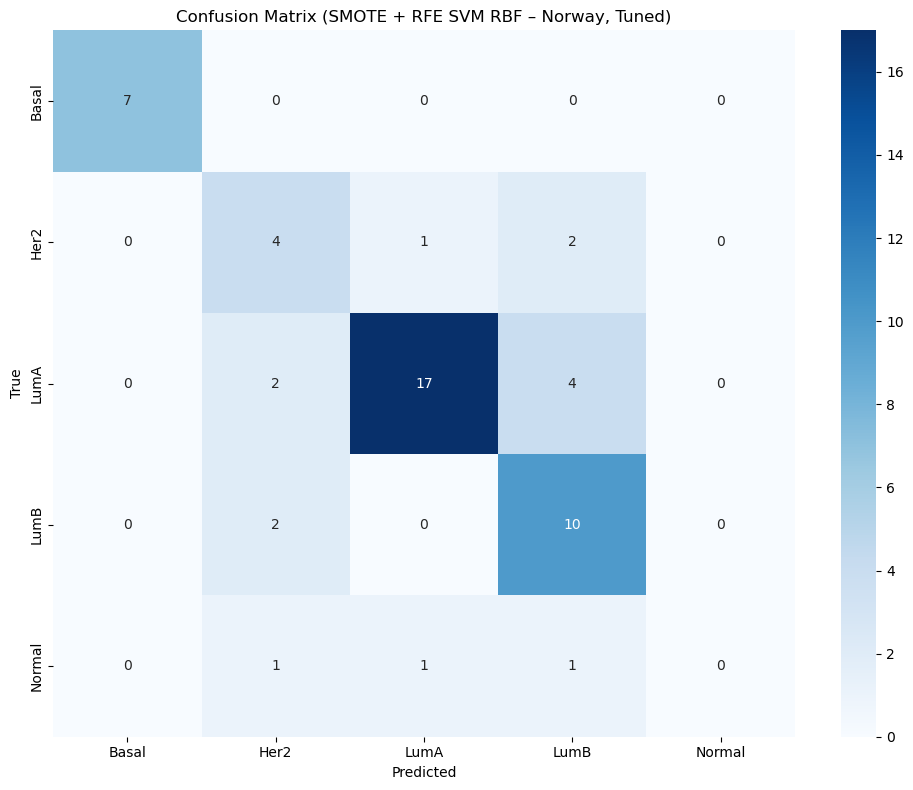

Model saved as pipelineSmoteRfeTune_Norway.pkl

Norway Test Macro-Average AUC-PR (SMOTE + RFE SVM RBF, Tuned): 0.687


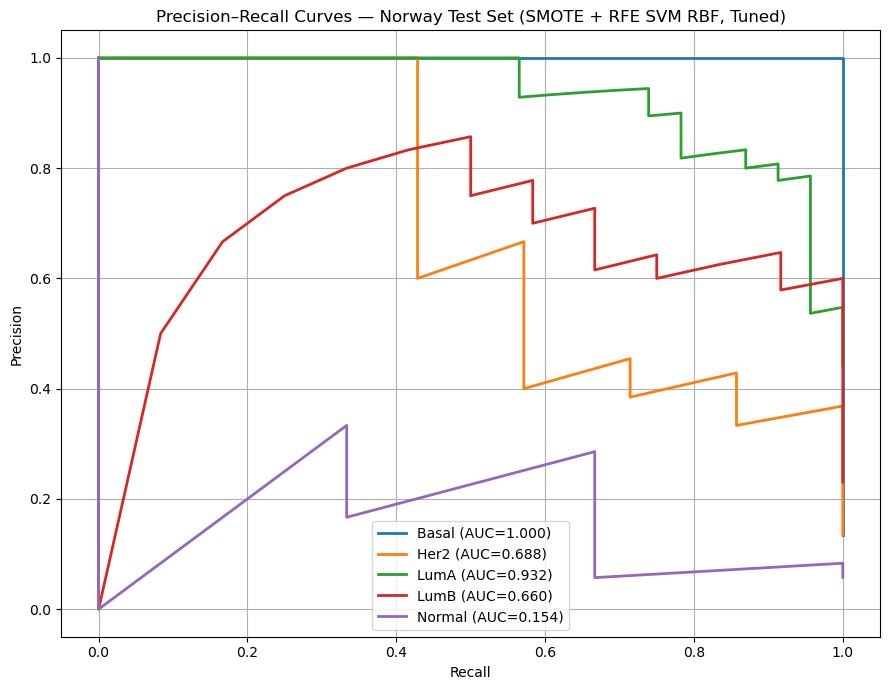

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

# -------------------------------
# 1. Define SMOTE + RFE + SVM RBF (tuned)
# -------------------------------
pipelineSmoteRfeTuneNorway = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rfe', RFE(estimator=LinearSVC(random_state=42, dual=False),
                n_features_to_select=500, step=0.20, verbose=1)),
    ('svm', SVC(kernel='rbf',
                probability=True,
                random_state=42))
])

# -------------------------------
# 2. Train pipeline on Norway
# -------------------------------
param_dist = [
    {  # linear
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['linear'],
        'svm__C': loguniform(1e-3, 1e3)
    },
    {  # rbf
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['rbf'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1)
    },
    {  # poly
        'rfe__n_features_to_select': [100, 500, 1000],
        'rfe__step': [0.2, 0.25, 0.5],
        'svm__kernel': ['poly'],
        'svm__C': loguniform(1e-3, 1e3),
        'svm__gamma': loguniform(1e-6, 1e-1),
        'svm__degree': randint(2, 6),
        'svm__coef0': loguniform(1e-3, 1e1)
    }
]

rand = RandomizedSearchCV(
    estimator=pipelineSmoteRfeTuneNorway,
    param_distributions=param_dist,
    n_iter=50,                    
    scoring='f1_weighted',
    cv=3,
    n_jobs=10,
    verbose=3,
    random_state=42
)


rand.fit(X_train_Norway, y_train_Norway)
print(rand.best_params_)
pipelineSmoteRfeTuneNorway = rand.best_estimator_

# -------------------------------
# 3. Predict & Evaluate
# -------------------------------
y_pred = pipelineSmoteRfeTuneNorway.predict(X_test_Norway)
print("\nTest Accuracy (SMOTE + RFE SVM RBF, Norway, tuned):", accuracy_score(y_test_Norway, y_pred))
print("\nModel Evaluation on Test Data:")
print(classification_report(y_test_Norway, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test_Norway, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test_Norway),
            yticklabels=np.unique(y_test_Norway))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (SMOTE + RFE SVM RBF – Norway, Tuned)')
plt.tight_layout()
plt.show()

# -------------------------------
# 4. Save the trained model
# -------------------------------
joblib.dump(pipelineSmoteRfeTuneNorway, "pipelineSmoteRfeTune_Norway.pkl")
print("Model saved as pipelineSmoteRfeTune_Norway.pkl")

# -------------------------------
# 5. Precision–Recall Curves (multiclass)
# -------------------------------
classes = pipelineSmoteRfeTuneNorway.named_steps['svm'].classes_

# Binarize true labels
y_test_bin = label_binarize(y_test_Norway, classes=classes)

# Predicted probabilities
y_proba = pipelineSmoteRfeTuneNorway.predict_proba(X_test_Norway)

plt.figure(figsize=(9, 7))
auc_list = []

for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    auc_pr = auc(recall, precision)
    auc_list.append(auc_pr)
    plt.plot(recall, precision, linewidth=2, label=f"{cls} (AUC={auc_pr:.3f})")

macro_auc = sum(auc_list) / len(auc_list)
print(f"\nNorway Test Macro-Average AUC-PR (SMOTE + RFE SVM RBF, Tuned): {macro_auc:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves — Norway Test Set (SMOTE + RFE SVM RBF, Tuned)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("PR_curve_Norway_SMOTE_RFE_TUNED_RBF.png", dpi=300)
plt.show()


## No Random Search No RFE

## No Random Search RFE

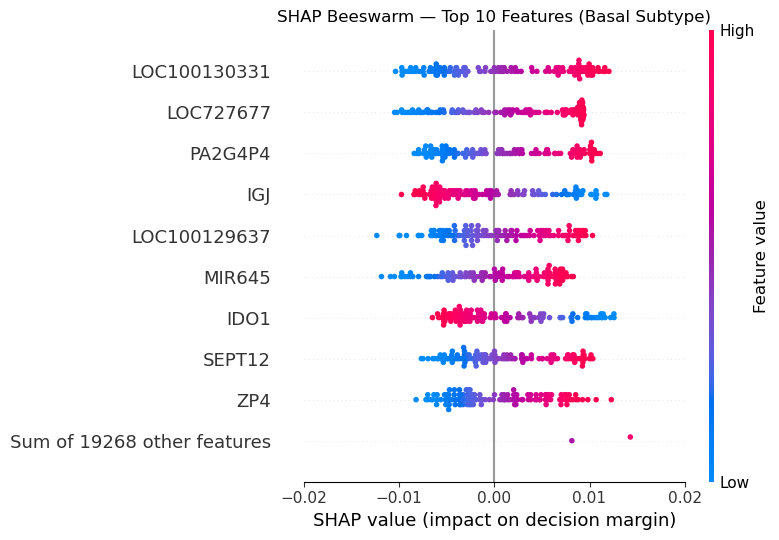

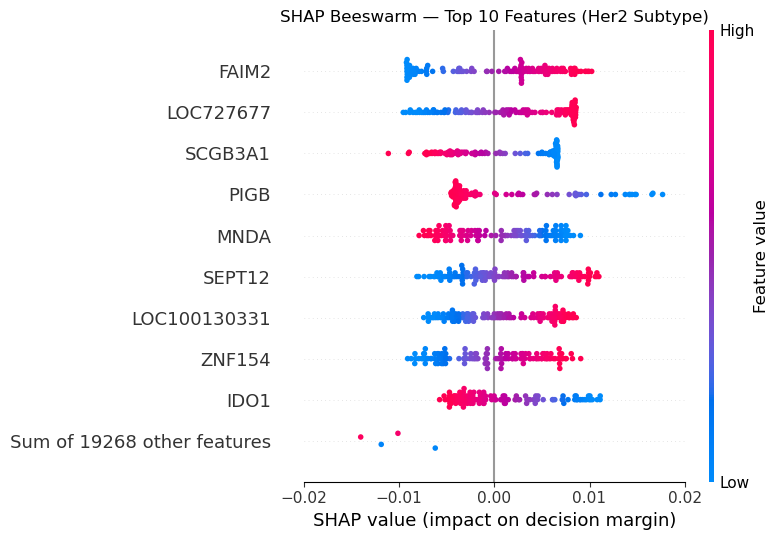

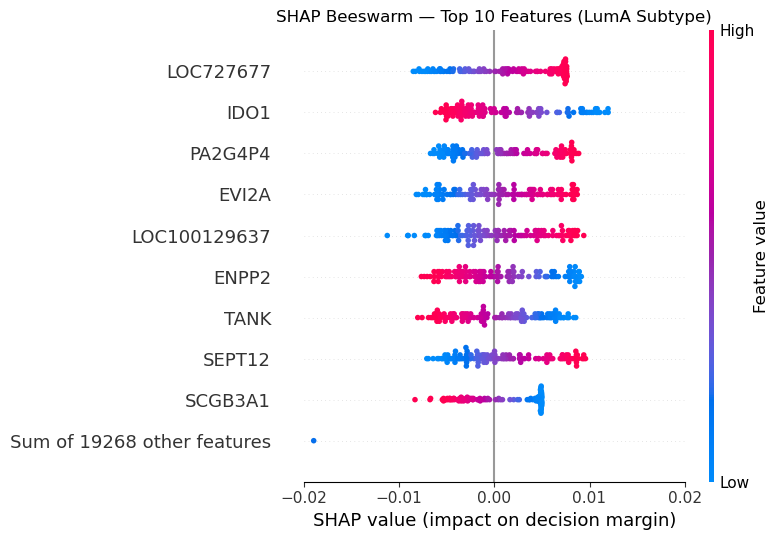

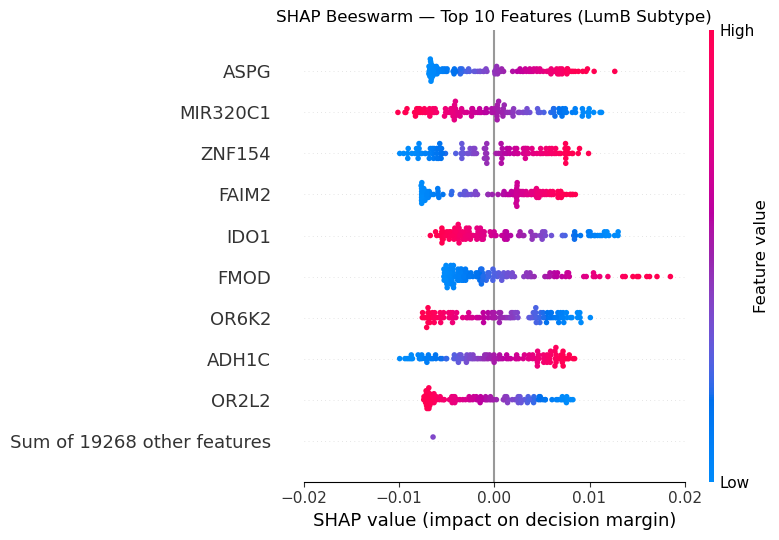

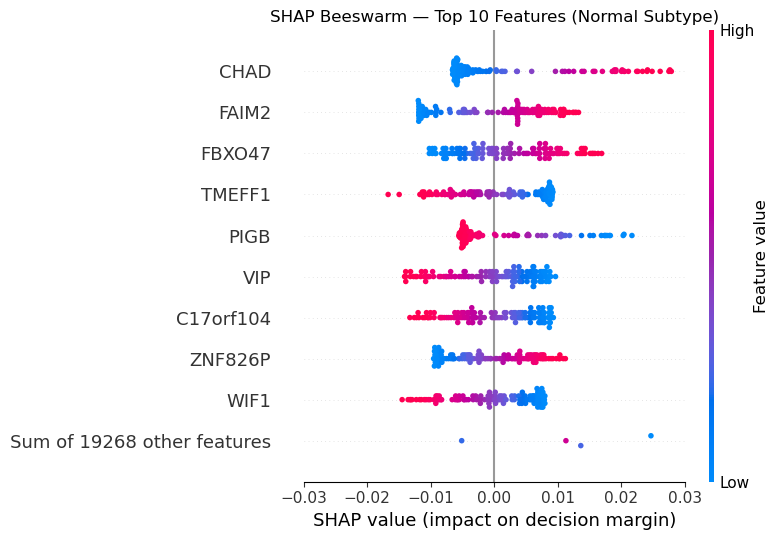

In [40]:
# --- Create SHAP explainer (linear kernel → fast linear explainer)
svm = pipelineSmote.named_steps['svm']

bg = shap.sample(X_train, 200, random_state=42) if len(X_train) > 200 else X_train
masker = shap.maskers.Independent(bg)
explainer = shap.Explainer(svm, masker=masker, algorithm="linear")

# Compute SHAP values (multiclass)
sv = explainer(X_test)

# --- Generate and SHOW the plots (Top 10 features, x-ticks every 0.01)
from matplotlib.ticker import MultipleLocator
import numpy as np
class_names = pd.Index(svm.classes_)

for ci, cname in enumerate(class_names):
    sv_c = sv[:, :, ci]  # SHAP for this class

    # symmetric x-limits rounded to nearest 0.01
    vmax = float(np.nanmax(np.abs(np.asarray(sv_c.values))))
    xmax = max(0.01, np.ceil(vmax * 100) / 100.0)

    plt.figure(figsize=(8, 5.5))
    shap.plots.beeswarm(sv_c, max_display=10, show=False)
    ax = plt.gca()
    ax.set_title(f"SHAP Beeswarm — Top 10 Features ({cname} Subtype)")
    ax.set_xlabel("SHAP value (impact on decision margin)")
    ax.set_xlim(-xmax, xmax)
    ax.xaxis.set_major_locator(MultipleLocator(0.01))
    plt.tight_layout()
    plt.show()
